In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [15]:
# Root directory for dataset

dataroot = "fc_matrices/schaefer"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 100

# size of reduced matrix to be input
reduced_dim = int(np.ceil((float(image_size * (image_size - 1)) / 2.0)**0.5))

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of bottleneck vector (i.e. size of generator input)
nz = 100

# Size of feature maps in discriminator
nf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [16]:
import os
import sys
sys.path.append('../')
from utils import BrainGraphDataset, project_root

root = project_root()
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, 'annotations.csv'),
                           transform=None, setting='graph')

training_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

# Create the dataloader

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
from old_models import AutoEncoder

# Create the generator
netAE = AutoEncoder(nf, nc).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netAE.apply(weights_init)

# Print the model
print(netAE)

AutoEncoder(
  (decoder): Decoder(
    (layers): Sequential(
      (0): ConvTranspose2d(256, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Tanh()
      (9): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Tanh()
      (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoder): Encoder(
    (layers): Se

In [19]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizer
optimizer = optim.Adam(netAE.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
folds = 4

cross_val_datasets = torch.utils.data.random_split(training_dataset, [1. / float(folds)] * folds) 

img_list = []

training_losses = [[] for _ in range(folds)]
test_losses = [0] * folds

iters = 0
epochs = 100

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

for k in range(folds):

    # k fold cross validation
    training_datasets = torch.utils.data.ConcatDataset(cross_val_datasets[0:k] + cross_val_datasets[k+1:folds])

    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)
    validation_dataloader = torch.utils.data.DataLoader(cross_val_datasets[k], batch_size=batch_size,
                                            shuffle=True, num_workers=workers)
    # Training Loop

    # Keep track of progress
    best_val_error = float('inf')
    best_weights = {}

    print("Starting Training Loop...")
    # For each epoch
    print('Fold ', k)

    # Reset the weights
    netAE.apply(weights_init)

    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(training_dataloader, 0):
            ###########################
            ## Train 
            netAE.train()
            netAE.zero_grad()
            # Format batch
            cpu = data[0].to(device).float().view(-1, 1, 100, 100) 

            output = netAE(cpu)

            # Calculate loss
            err = criterion(output, cpu.view(output.shape))
            # Calculate gradients for AE in backward pass
            err.backward()
            # 1 step of gradient descent
            optimizer.step()

            training_losses[k].append(err.item())
            iters += 1

        # If we get a better performance with validation set,
        # save current weights as the best
        for i, data in enumerate(validation_dataloader, 0):
            cur_val_error = 0

            netAE.eval()
            cpu = data[0].to(device).float()
            output = netAE(cpu.view(-1, 1, 100, 100))

            cur_val_error += criterion(output, cpu.view(output.shape)).item()

        if cur_val_error < best_val_error:
            best_weights = netAE.state_dict()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch} {err.item()}, {cur_val_error}')

    # Evaluate the test set using the best weights according
    # to the validation set
    netAE.load_state_dict(best_weights)
    for i, data in enumerate(test_dataloader, 0):
        netAE.eval()
        cpu = data[0].to(device).float().view(-1, 1, 100, 100) 
        output = netAE(cpu)

        test_losses[k] += criterion(output, cpu).item()

torch.save(netAE.encoder.state_dict(), os.path.join(root, 'encoder_weights.pt'))
torch.save(netAE.decoder.state_dict(), os.path.join(root, 'decoder_weights.pt'))

In [21]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder Validation Loss During Training")

plt.plot(np.average(training_losses, 0))
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(test_losses)

In [22]:
encoder.load_state_dict(netAE.encoder.state_dict(), 'encoder_weights.pt')
decoder.load_state_dict('decoder_weights.pt')

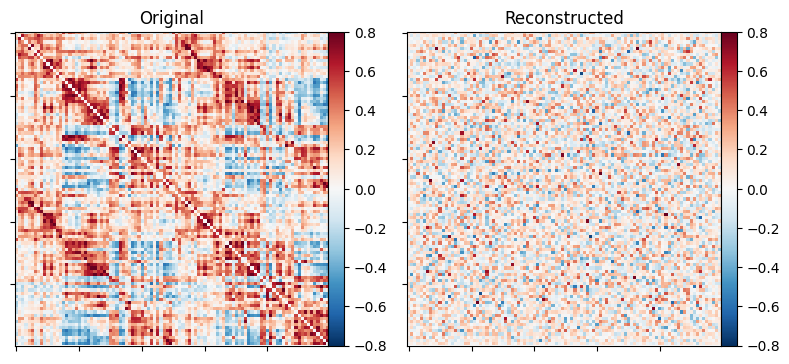

In [23]:
import matplotlib.pyplot as plt
from nilearn import plotting

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=workers)

# select a batch from the validation data loader
data, _ = next(iter(test_dataloader))

# pass the batch through the trained model to obtain the reconstructed output
recon, _, _, _ = netAE(data.view(-1, 1, 100, 100))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(1):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(data[i], colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()
